In [44]:
#imports
from scipy.spatial import distance_matrix
from random import randrange
import copy
import matplotlib.pyplot as plt
import imageio
import random
from time import time
from tqdm import tqdm

In [3]:
#loading datasets 
import numpy as np
kroa={}
krob={}
np_kroa=[]
np_krob=[]
with open('kroa100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        kroa[x[0]]=(x[1],x[2])
        np_kroa.append((x[1],x[2]))
np_kroa=np.array(np_kroa)
with open('krob100.txt') as f:
    lines = f.readlines()
    for line in lines[6:-1]:
        x=list(map(int,line.strip().split(' ')))
        #print(x)
        krob[x[0]]=(x[1],x[2])
        np_krob.append((x[1],x[2]))

np_kroa=np.array(np_kroa)
np_krob=np.array(np_krob)

#calculating distance matrix - https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance_matrix.html
dista=distance_matrix(np_kroa,np_kroa)
distb=distance_matrix(np_krob,np_krob)

In [4]:
#plotting functions
def plotResult(np_dots, cycles):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.show()
    
def plotPartResult(np_dots, cycles,i=0):
    plt.plot(np_dots[:,0][cycles[0][0]], np_dots[:,1][cycles[0][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[1][0]], np_dots[:,1][cycles[1][0]], "o", markersize=12)
    plt.plot(np_dots[:,0][cycles[0]], np_dots[:,1][cycles[0]], "->")
    plt.plot(np_dots[:,0][cycles[1]], np_dots[:,1][cycles[1]], "->")
    plt.plot(np_dots[:,0], np_dots[:,1], ".")
    #plt.savefig(f'plots/{i}.png')
    plt.show()    
    
def calcDistance(currentCycle, dist):
    distance = 0
    for x,y in zip(currentCycle, [*currentCycle[1:], currentCycle[0]]):
        distance += dist[x][y]
    return distance 

In [5]:
# 1st variable - Start cycle - with random assignments
def start_cycle_random(dataset_choice="kroa"):
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)
    candidates=np.arange(0,100,1)
    #print(candidates)
    cycles={}
    cycles[0]=[randrange(100)]
    candidates=np.delete(candidates, cycles[0][0])
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]
    candidates=np.delete(candidates, cycles[1][0])
    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        chosenElementIndex = np.random.randint(len(candidates))
        #print(chosenElementIndex,len(candidates),candidates[chosenElementIndex])
        #cycles[chosenCycle]=np.insert(cycles[chosenCycle],candidates[chosenElementIndex])
        cycles[chosenCycle]=np.concatenate((cycles[chosenCycle], [candidates[chosenElementIndex]]), axis=0)
        candidates=np.delete(candidates, chosenElementIndex)
    return cycles


In [40]:
# 1st variable - Start cycle - with nearest neighbour method
def starty_cycle_heuristic(dataset_choice="kroa"):
    results=[]
    min_result=np.inf
    max_result=0
    if dataset_choice=="kroa":
        dataset=np_kroa
        dic=kroa
        dist=copy.deepcopy(dista)
        dist_stable=copy.deepcopy(dista)
    else:
        dataset=np_krob
        dic=krob
        dist=copy.deepcopy(distb)
        dist_stable=copy.deepcopy(distb)


    #zmiana dystansu przekątnej na nieskonczonosc
    np.fill_diagonal(dist, np.inf)

    cycles={}
    cycles[0]=[randrange(100)]
    cycles[1]=[(np.argsort(dist[cycles[0][0]])[-2])]

    for b in range(2):
        dist[:,int(cycles[b][0])]=np.inf

    chosenCycle=1
    for i in range(0,98):
        chosenCycle = int((chosenCycle + 1)%2)
        candidates=[]
        for z,index in enumerate(cycles[chosenCycle]):
            candidates.append((np.argmin(dist[index]),np.min(dist[index]),z))
        candidates=np.array(candidates)
        x=np.argmin(candidates[:,1])
        cycles[chosenCycle]=np.insert(cycles[chosenCycle],int(candidates[x,2]),int(candidates[x,0]))
        dist[:,int(candidates[x,0])]=np.inf
    
#     print(f"cycle[0]: {calcDistance(cycles[0], dist_stable)}")
#     print(f"cycle[1]: {calcDistance(cycles[1], dist_stable)}")
    
    #SAVING RESULTS 
    results.append(calcDistance(cycles[0],dist_stable)+calcDistance(cycles[1],dist_stable))
    if results[-1]>max_result:
        max_result=results[-1]
    if results[-1]<min_result:
        min_result=results[-1]
        plt.clf()
        plt.plot(dataset[:,0][cycles[0][0]], dataset[:,1][cycles[0][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[1][0]], dataset[:,1][cycles[1][0]], "o", markersize=12)
        plt.plot(dataset[:,0][cycles[0]], dataset[:,1][cycles[0]], "->")
        plt.plot(dataset[:,0][cycles[1]], dataset[:,1][cycles[1]], "->")
        plt.savefig(f'best_NN_{dataset_choice}.png')
    return cycles

In [15]:
# 2nd variable - Find more optimal solution
# switch parameter defines how u find neighbour solutions (is it change_vertices or change_edges func)
def greedy_search(dist, np_dots, init_random = False, switch="change_edges"):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = starty_cycle_heuristic()
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
    print(f"Initial distance: {bestDistance}")
    
    plotPartResult(np_dots, cycles)
    
    
    done = False
    while not done:
        done = True
        for _ in range(10000):
            cyclesCopy = copy.deepcopy(cycles)
            if random.random() > 0.5:
                cycle = 0
            else:
                cycle = 1

            if random.random() > 0.5:
                edge1 = random.randint(0, 49)
                edge2 = random.randint(edge1, 49)
#                 print(edge1, edge2)
                internal_change(cyclesCopy[cycle], edge1, edge2)
            else:
    #             change_vertices()
                pass
#             plotPartResult(np_dots, cycles)
            currentDistance = 0
            currentDistance += calcDistance(cyclesCopy[0], dist)
            currentDistance += calcDistance(cyclesCopy[1], dist)
            if currentDistance < bestDistance:
                print(f"New best distance: {currentDistance}")
                cycles = cyclesCopy
                bestDistance = currentDistance
                done = False
    
    plotPartResult(np_dots, cycles)
    plt.show()
    
    

In [8]:
# 2nd variable - Find more optimal solution
def steep_search(cycleA, cycleB):
    raise NotImplementedError

In [9]:
# 3rd variable - Generate neighbour solution
#changes vertex internally or externaly between cycles
def change_vertices():
    pass

In [10]:
# 3rd variable - Generate neighbour solution
#changes edges internally
def change_edges(cycle, edge1, edge2):
    edge1 += 1
    edge2 += 1
    cycle[edge1: edge2] = np.flip(cycle[edge1: edge2])
    return cycle

In [46]:
# algorytm losowego bładzenia który robi losowo wybrany ruch jako punkt odniesienia wzgledem rozwiazan steep search i greedy search
def random_wandering(dist, np_dots, duration, init_random = False, switch="change_edges"):
    #specify cycles initialization.
    if init_random:
        cycles = start_cycle_random()
    else:
        cycles = starty_cycle_heuristic()
    
    if switch == "change_vertices":
        internal_change = change_vertices
    elif switch == "change_edges":
        internal_change = change_edges
    else:
        print(f"Unknow mode {switch}. Select change_vertices or change_edges")
        return
    
    bestDistance = 0
    bestDistance += calcDistance(cycles[0], dist) 
    bestDistance += calcDistance(cycles[1], dist) 
#     print(f"Initial distance: {bestDistance}")
    
#     plotPartResult(np_dots, cycles)
    
    startTime = time()
    done = False
    while not done:
        done = True
        while True:
            if random.random() > 0.5:
                cycle = 0
            else:
                cycle = 1

            if random.random() > 0.5:
                edge1 = random.randint(0, 49)
                edge2 = random.randint(edge1, 49)
#                 print(edge1, edge2)
                internal_change(cycles[cycle], edge1, edge2)
            else:
    #             change_vertices()
                pass
#             plotPartResult(np_dots, cycles)
#             currentDistance = 0
#             currentDistance += calcDistance(cycles[0], dist)
#             currentDistance += calcDistance(cycles[1], dist)
            if time() - startTime > duration:
                break
                done = False
    
#     plotPartResult(np_dots, cycles)
#     plt.show()
    
    currentDistance = 0
    currentDistance += calcDistance(cycles[0], dist)
    currentDistance += calcDistance(cycles[1], dist)
    return currentDistance

100%|██████████| 100/100 [01:59<00:00,  1.20s/it]

random_wandering; time:1.1957372832298279, min:100113.35297990218, max:145550.3294451778, mean:120324.36337005021


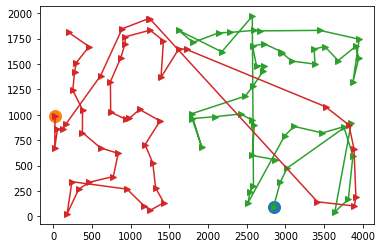

In [47]:
#MAIN - tu poskladac wyzej zaimplementowane funkcje w 8 roznych kombinacji algorytmow i sprawdzic ich czasy i wyplotowac skutecznosci

timeTable = []
distanceTable = []
bestDistance = 0
for _ in tqdm(range(100)):
    startTime = time()
    distanceTable.append(random_wandering(dista, np_kroa, 1))
    timeTable.append(time() - startTime)
print(f"random_wandering; time:{np.mean(timeTable)}, min:{np.min(distanceTable)}, max:{np.max(distanceTable)}, mean:{np.mean(distanceTable)}")


In [48]:
combinations = mesh.T.reshape(-1,2)

NameError: name 'mesh' is not defined